In [12]:

import pickle
import sys
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from rotations import Quaternion, skew_symmetric
sys.path.append('./data')

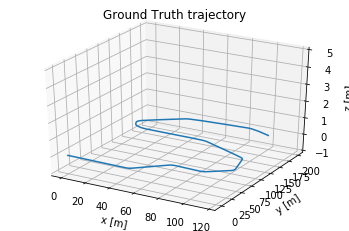

In [13]:

#### 1. Data ###################################################################################

################################################################################################
# This is where you will load the data from the pickle files. For parts 1 and 2, you will use
# p1_data.pkl. For part 3, you will use p3_data.pkl.
################################################################################################
with open('data/p1_data.pkl', 'rb') as file:
    data = pickle.load(file)

################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

################################################################################################
# Let's plot the ground truth trajectory to see what it looks like. When you're testing your
# code later, feel free to comment this out.
################################################################################################
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [44]:
Quaternion(*q_est[0]).to_mat().dot(np.array(imu_f.data[0].T) - g)

array([array([0.00574242]), array([-0.00227575]), array([-0.01075089])],
      dtype=object)

In [89]:
print(gnss.data[0])
print(lidar.data[0])

[-0.0226153  -0.13252318 -0.04939175]
[8.25736645 6.79774012 6.62382962]


In [99]:
print(imu_f.t)
print(lidar.t)

[ 2.055  2.06   2.065 ... 56.64  56.645 56.65 ]
[ 2.055  2.16   2.265  2.37   2.475  2.58   2.685  2.79   2.895  3.
  3.105  3.21   3.315  3.42   3.525  3.63   3.735  3.84   3.945  4.05
  4.15   4.255  4.355  4.46   4.565  4.67   4.775  4.88   4.98   5.085
  5.19   5.295  5.4    5.505  5.605  5.71   5.815  5.92   6.025  6.13
  6.23   6.335  6.44   6.545  6.65   6.755  6.855  6.96   7.065  7.17
  7.275  7.38   7.48   7.585  7.69   7.795  7.9    8.005  8.11   8.21
  8.315  8.42   8.525  8.63   8.735  8.835  8.94   9.045  9.15   9.255
  9.36   9.46   9.565  9.67   9.775  9.88   9.985 10.085 10.19  10.295
 10.4   10.505 10.61  10.71  10.815 10.92  11.025 11.13  11.235 11.335
 11.44  11.545 11.65  11.755 11.86  11.96  12.065 12.17  12.275 12.38
 12.485 12.585 12.69  12.795 12.9   13.005 13.11  13.21  13.315 13.42
 13.525 13.63  13.735 13.835 13.94  14.045 14.15  14.255 14.36  14.46
 14.565 14.67  14.775 14.88  14.985 15.085 15.19  15.295 15.4   15.505
 15.61  15.71  15.815 15.92  16.025 16.

In [102]:
################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can just insert it into our solver as another position
# measurement, just as we do for GNSS. However, the LIDAR frame is not the same as the frame
# shared by the IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame
# using our known extrinsic calibration rotation matrix C_li and translation vector t_li_i.
#
# THIS IS THE CODE YOU WILL MODIFY FOR PART 2 OF THE ASSIGNMENT.
################################################################################################
# This is the correct calibration rotation matrix, corresponding to an euler rotation of 0.05, 0.05, .1.
C_li = np.array([
    [ 0.99376, -0.09722,  0.05466],
    [ 0.09971,  0.99401, -0.04475],
    [-0.04998,  0.04992,  0.9975 ]
])

# This is an incorrect calibration rotation matrix, corresponding to a rotation of 0.05, 0.05, 0.05
# C_li = np.array([
#     [ 0.9975 , -0.04742,  0.05235],
#     [ 0.04992,  0.99763, -0.04742],
#     [-0.04998,  0.04992,  0.9975 ]
# ])

t_li_i = np.array([0.5, 0.1, 0.5])

lidar.data = (C_li @ lidar.data.T).T + t_li_i


#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
var_imu_f = 0.1
var_imu_w = 1.0
var_gnss = 0.01
var_lidar = 0.25

################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian


#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.eye(9)  # covariance of estimate
gnss_i = 0
lidar_i = 0


#### 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    # 3.1 Compute Kalman Gain

    # 3.2 Compute error state

    # 3.3 Correct predicted state

    # 3.4 Compute corrected covariance

    return p_check, v_check, q_check, p_cov_check


#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]
    # 1. Update state with IMU inputs
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    
    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + (delta_t**2 / 2) * (C_ns.dot(imu_f.data[k-1].T) - g)
    
    v_est[k] = v_est[k-1] + delta_t * (C_ns.dot(imu_f.data[k-1].T) - g)
    
    omega_q = Quaternion(axis_angle=imu_w.data[k-1]*delta_t)
    
    q_est[k] = omega_q.quat_mult(Quaternion(*q_est[k-1]))
    # 1.1 Linearize Motion Model
    F = np.eye(9)
    F[0:3, 3:6] = delta_t * np.eye(3)
    F[3:6, 6:9] = -skew_symmetric(C_ns.dot(imu_f.data[k-1].T)) * delta_t
    Q = np.eye(6)
    Q[0:3, 0:3] = (var_imu_f) * np.eye(3) 
    Q[3:6, 3:6] = (var_imu_w) * np.eye(3) 
    Q = (delta_t ** 2) * Q
    # 2. Propagate uncertainty
    p_cov[k] = F.dot(p_cov[k-1]).dot(F.T) + l_jac.dot(Q).dot(l_jac.T)
    # 3. Check availability of GNSS and LIDAR measurements
    curr_lidar_idx = 0
    curr_gnss_idx = 0
    lidar_time_diff = gnss.t[curr_gnss_idx] - imu_f.t[k]
    gnss_time_diff = lidar.t[curr_gnss_idx] - imu_f.t[k]
    if np.abs(lidar_time_diff) <= 0.01:
        y_k = h_jac.dot(lidar.data[curr_lidar_idx].T) + np.eye(3) * var_lidar
        print(y_k.shape)
        quit()
        #measurement_update(var_lidar, p_cov[k], y_k, p_check=p_est[k], v_check=v_est[k], q_check=q_est[k])
        curr_gnss_idx += 1


#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data, let's plot the results. This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Final Estimated Trajectory')
ax.legend()
ax.set_zlim(-1, 5)
plt.show()

################################################################################################
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty
# included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty.
################################################################################################
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error plots')
num_gt = gt.p.shape[0]
p_est_euler = []

# Convert estimated quaternions to euler angles
for q in q_est:
    p_est_euler.append(Quaternion(*q).to_euler())
p_est_euler = np.array(p_est_euler)

# Get uncertainty estimates from P matrix
p_cov_diag_std = np.sqrt(np.diagonal(p_cov, axis1=1, axis2=2))

titles = ['x', 'y', 'z', 'x rot', 'y rot', 'z rot']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])

for i in range(3):
    ax[1, i].plot(range(num_gt), gt.r[:, i] - p_est_euler[:num_gt, i])
    ax[1, i].plot(range(num_gt), 3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_diag_std[:num_gt, i+6], 'r--')
    ax[1, i].set_title(titles[i+3])
plt.show()


#### 7. Submission #############################################################################


ValueError: shapes (3,9) and (3,) not aligned: 9 (dim 1) != 3 (dim 0)

In [ ]:

################################################################################################
# Now we can prepare your results for submission to the Coursera platform. Uncomment the
# corresponding lines to prepare a file that will save your position estimates in a format
# that corresponds to what we're expecting on Coursera.
################################################################################################

# Pt. 1 submission
p1_indices = [9000, 9400, 9800, 10200, 10600]
p1_str = ''
for val in p1_indices:
    for i in range(3):
        p1_str += '%.3f ' % (p_est[val, i])
with open('pt1_submission.txt', 'w') as file:
    file.write(p1_str)

# Pt. 2 submission
# p2_indices = [9000, 9400, 9800, 10200, 10600]
# p2_str = ''
# for val in p2_indices:
#     for i in range(3):
#         p2_str += '%.3f ' % (p_est[val, i])
# with open('pt2_submission.txt', 'w') as file:
#     file.write(p2_str)

# Pt. 3 submission
# p3_indices = [6800, 7600, 8400, 9200, 10000]
# p3_str = ''
# for val in p3_indices:
#     for i in range(3):
#         p3_str += '%.3f ' % (p_est[val, i])
# with open('pt3_submission.txt', 'w') as file:
#     file.write(p3_str)